## Square Attack

The Square Attack is a query-efficient black-box method used to generate adversarial samples. Being a 'black-box' approach, the Square Attack does not require knowing model weights or gradients - it requires much less information than a white-box approach (eg. PGD or FGSM). The Square Attack is additionally a 'query-efficient' black-box attack. This is because where other black box methods make many queries to the model in order to perform attacks (eg. gradient estimation), the square attack makes relatively few.  It generally consists of trying a random alteration on a decreasing 'square' of the image, and keeping it if it increases the loss of the model. The $ L_\infty $ and $ L_2. $ approaches use different sampling distributions to change pixel values in the squares. Square Attack, upon release, was successful enough that it even outperformed some existing white-box approaches on benchmarks.



## 1. Loading and Processing Models and Images

In [44]:
from xlab.utils import prediction, process_image, show_image, SimpleCNN, CIFAR10
import torch
import numpy as np
import random
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock
import torch
classes = CIFAR10().classes
IMG_PATH = 'car.jpg'
model = MiniWideResNet()
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only = False)

## 2. The $ L_\infty $ Attack

### Task 1
First, we will start by making a helper function for the $ L_\infty $ attack. This will be the function for creating the distribution used to alter squares. In this algorithm, two corner indices $ r, s $ are randomly sampled, and are used with the window size $ h $ to create a window, which is then altered. The perturbation $ p $, used to alter the pixels in the window, is randomly sampled between $ -2\epsilon $ and $ 2\epsilon $. Each colour channel is altered separately, with the same window being changed in each.

<strong>Algorithm 2:</strong> Sampling distribution $P$ for $l_\infty$-norm
<hr>
<strong>Input:</strong> maximal norm $\epsilon$, window size $h$, image size $w$, color channels $c$<br>
<strong>Output:</strong> New update $\delta$
<hr>

<table align='left'>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">1</td>
    <td>$\delta \leftarrow \text{array of zeros of size } w \times w \times c$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">2</td>
    <td>sample uniformly<br>$r, s \in \{0, \dots, w - h\} \subset \mathbb{N}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">3</td>
    <td><b>for</b> $i = 1, \dots, c$ <b>do</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">4</td>
    <td style="padding-left: 2em;">$\rho \leftarrow \text{Uniform}(\{-2\epsilon, 2\epsilon\})$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">5</td>
    <td style="padding-left: 2em;">$\delta_{r+1:r+h, s+1:s+h, i} \leftarrow \rho \cdot \mathbf{1}_{h \times h}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">6</td>
    <td><b>end</b></td>
  </tr>
</table>

<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution we use ```torch.zeros``` to create a null matrix of the right shape and then add the individual values.

</details>
<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution, we index for the window using:
```arr[a:b+c][d:e+f]```

</details>

<details>
<summary>🔐 <b>Solution for Task #1</b></summary>

```python
def l_inf_dist(epsilon, h, w, c):
    """Calculates the delta update for l_inf distribution.
    
    Args:
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor containing updates for each channel.
    """
    delta = torch.zeros(c, w, w)
    r,s = np.random.randint(32-h, size = (2))
    for channel in range(c):
        unif = np.random.uniform(-2*epsilon, 2*epsilon)
        delta[channel][r:r+h, s:s+h] = unif
    return delta
```

</details>

In [46]:
def l_inf_dist(epsilon, h, w, c):
    """Calculates the delta update for l_inf distribution.
    
    Args:
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    """
    delta = torch.zeros(c, w, w)
    r,s = np.random.randint(w-h, size = (2))
    for channel in range(c):
        unif = np.random.uniform(-2*epsilon, 2*epsilon)
        delta[channel][r:r+h, s:s+h] = unif
    return delta
    return None

In [48]:
from xlab.tests import section2_3
_ = section2_3.task1(l_inf_dist)


Running tests for Task 1...
🎉 All tests passed! (4/4)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 4 items

..\xlab-python-package\xlab\tests\section2_3.py::TestTask1::test_output_shape_and_type PASSED                    [ 25%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask1::test_values_in_range PASSED                          [ 50%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask1::test_patch_structure PASSED                          [ 75%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask1::test_reproducibility_with_seed PASSED                [100%]

================================================== 4 passed in 0.13s ==================================================



## 2.1 The Square Attack loop.
### Task 2
Now, we will use the distribution within the main loop of the  $ L_\infty $ attack. Similar code will be used to run the $ L_2 $ attack. Intuitively, this algorithm involves choosing a window size $ h $ using a schedule of sorts, and then altering the image using the above helper function, until the image is adversarial or a particular number of iterations is reached.

<hr>
<strong>Input:</strong> classifier $f$, point $x \in \mathbb{R}^d$, image size $w$, number of color channels $c$,<br>
$l_p$-radius $\epsilon$, label $y \in \{1, \dots, K\}$, number of iterations $N$<br>
<strong>Output:</strong> approximate minimizer $\hat{x} \in \mathbb{R}^d$ of the problem stated in Eq. (1)
<hr>

<table align='left'>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">1</td>
    <td>$\hat{x} \leftarrow \text{init}(x), \quad l^* \leftarrow L(f(x), y), \quad i \leftarrow 1$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">2</td>
    <td><b>while</b> $i < N$ and $\hat{x}$ is not adversarial <b>do</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">3</td>
    <td style="padding-left: 2em;">$h^{(i)} \leftarrow$ side length of the square to modify (according to some schedule)</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">4</td>
    <td style="padding-left: 2em;">$\delta \sim P(\epsilon, h^{(i)}, w, c, \hat{x}, x)$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">5</td>
    <td style="padding-left: 2em;">$\hat{x}_{\text{new}} \leftarrow \text{Project } \hat{x} + \delta \text{ onto } \{z \in \mathbb{R}^d : \|z - x\|_p \le \epsilon\} \cap [0, 1]^d$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">6</td>
    <td style="padding-left: 2em;">$l_{\text{new}} \leftarrow L(f(\hat{x}_{\text{new}}), y)$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">7</td>
    <td style="padding-left: 2em;"><b>if</b> $l_{\text{new}} < l^*$ <b>then</b> $\hat{x} \leftarrow \hat{x}_{\text{new}}, l^* \leftarrow l_{\text{new}};$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">8</td>
    <td style="padding-left: 2em;">$i \leftarrow i + 1$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">9</td>
    <td><b>end</b></td>
  </tr>
</table>



<details>
<summary>💡 <b>Hint for Task #2</b></summary>

In our solution, we use the div operator, ```//``` for the floor function.
</details>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=15/1000, max_h = 6):
    """Creates an adversarial example for the l_inf distribution.
    
    Args:
        model: Trained neural network model with forward pass.
        loss_fn: Loss function used to train the network model.
        x: Input image tensor
        y: Label for input tensor
        N: Max number of iterations
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
        epsilon: Small number used for peturbation
        max_h: Maximum integer window length.
    
    Returns:
        adv_img: Adversarially perturbed image tensor
    """
    x_hat = x
    loss = loss_fn(model(x), y)
    i = 1
    h = max_h
    while i < N and prediction(model, x_hat)[0] == y:
        if i % (N // max_h) == 0:
            if h > 2:
                h -= 1
        delta = l_inf_dist(h=h, epsilon=epsilon, w=w, c=c)
        x_new = x_hat + delta
        x_new = torch.clamp(x_new, 0, 1)
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat
    return None

```

</details>

A basic schedule could involve reducing h by one (from max_h) every N//h iterations until the value of 2 is reached. This reduces the size of the window over time, reducing the scale of the perturbations, simulating a sort of convergence onto an adversarial image.

In [50]:
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=15/1000, max_h = 6):
    """Creates an adversarial example for the l_inf distribution.
    
    Args:
        model: Trained neural network model with forward pass.
        loss_fn: Loss function used to train the network model.
        x: Input image tensor
        y: Label for input tensor
        N: Max number of iterations
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
        epsilon: Small number used for peturbation
        max_h: Maximum integer window length.
    
    Returns:
        adv_img: Adversarially perturbed image tensor
    """
    x_hat = x
    loss = loss_fn(model(x), y)
    i = 1
    h = max_h
    while i < N and prediction(model, x_hat)[0] == y:
        if i % (N // max_h) == 0:
            if h > 2:
                h -= 1
        delta = l_inf_dist(h=h, epsilon=epsilon, w=w, c=c)
        x_new = x_hat + delta
        x_new = torch.clamp(x_new, 0, 1)
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat
    return None

In [56]:
_ = section2_3.task2(model, l_inf_square_attack)


Running tests for Task 2...
🎉 All tests passed! (1/1)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 1 item

..\xlab-python-package\xlab\tests\section2_3.py::TestTask2::test_output PASSED                                   [100%]

================================================== 1 passed in 1.42s ==================================================



truck with probability 0.5030


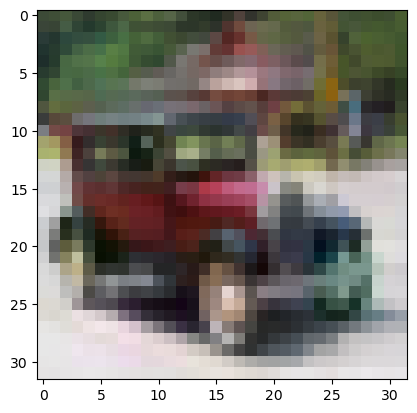

In [58]:
img = process_image(IMG_PATH)
label = prediction(model, process_image(IMG_PATH))[0]
loss_fn = torch.nn.CrossEntropyLoss()
x_adv = l_inf_square_attack(model, loss_fn, img, label, 500)
pred = prediction(model, x_adv)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")
show_image(x_adv)

## 3. The $ L_2 $ Attack
While the main loop of this attack is the same as the above, the distribution is entirely different. We will begin by producing the helper functions for this, and then the function itself. As the name suggests, the $L_2$ attack minimizes the $L_2$ difference between the original image and the perturbed one, so it is inherently slower and more complex. 

The $L_2$ distribution creates two adjacent rectangles of pixels (forming a square). The pixels in each rectangle have opposite signs. Placed together, this has a successfully adversarial effect. We will first create some helper functions for this, before moving on to implementing the distribution itself. This is significantly harder to implement than the $L_\infty$ attack, and has been included as more of an implementation challenge than anything. This section can be skipped through if found too challenging, but it is a good way to test your skills and practice using torch functions.

### Task 3
Code the M helper function for $L_2$ distribution. This function effectively creates a 'pyramidal' shape of values, with the highest value in the centre, and decreasing values radially around it. This is used to create adversarial perturbations - experiments show it to be an effective method.

$
M(r, s) = n - \max\{|r - \lfloor \frac{h_1}{2} \rfloor - 1|, |s - \lfloor \frac{h_2}{2} \rfloor - 1|\}
$

$where$ $n =  \lfloor \frac{h_1}{2}  \rfloor $


<details>
<summary>💡 <b>Hint for Task #3</b></summary>

In our solution, we use the div operator, ```//``` for the floor function.
</details>


<details>
<summary>🔐 <b>Solution for Task #3</b></summary>

```python
def M(r, s, h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        r: X coordinate
        s: Y coordinate
        h1: Square size
        h2: Floor of half Square size

    Returns:
        M: Calculated M value
    """
    n = h1 // 2
    return max(abs(r - h1 // 2 - 1), abs(s - h2 // 2 - 1))
```

</details>

In [60]:
def M(r, s, h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        r: X coordinate
        s: Y coordinate
        h1: Square size
        h2: Floor of half Square size

    Returns:
        M: Calaculated M value
    """
    n = h1 // 2
    return max(abs(r - h1 // 2 - 1), abs(s - h2 // 2 - 1))
    

In [62]:
_ = section2_3.task3(M)


Running tests for Task 3...
🎉 All tests passed! (2/2)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 2 items

..\xlab-python-package\xlab\tests\section2_3.py::TestTask3::test_return_type PASSED                              [ 50%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask3::test_known_values PASSED                             [100%]

================================================== 2 passed in 0.04s ==================================================



### Task 4
Code the eta helper function for the $L_2$ distribution. This, using the M helper function, creates a rectangle which has smoothed, radially decreasing pixel values. 

$
\eta_{r,s}^{(h_1,h_2)} = \sum_{k=0}^{M(r,s)} \frac{1}{(n+1-k)^2}
$

<details>
<summary>💡 <b>Hint for Task #4</b></summary>

In our solution, we use a cache for faster computation, but this is not necessary.
</details>


<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python
def eta(h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        h1: Square size
        h2: Floor of half Square size

    Returns:
        eta: Calculated eta tensor
    """
    n = h1 // 2
    m_matrix = torch.tensor([[M(i, j, h1, h2) for i in range(h2)] for j in range(h1)])
    max_value = torch.max(m_matrix)
    cache = []
    t_sum = 0
    for i in range(max_value):
        if n+1-i != 0: 
            t_sum += 1 / (n+1-i)
        cache.append(t_sum)
    cache = torch.tensor(cache)
    eta_matrix = cache[m_matrix - 1]
    return eta_matrix
```

</details>

In [64]:
def eta(h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        h1: Square size
        h2: Floor of half Square size

    Returns:
        eta: Calculated eta tensor
    """
    n = h1 // 2
    m_matrix = torch.tensor([[M(i, j, h1, h2) for i in range(h2)] for j in range(h1)])
    max_value = torch.max(m_matrix)
    cache = []
    t_sum = 0
    for i in range(max_value):
        if n+1-i != 0: 
            t_sum += 1 / (n+1-i)
        cache.append(t_sum)
    cache = torch.tensor(cache)
    eta_matrix = cache[m_matrix - 1]
    return eta_matrix


In [66]:
_ = section2_3.task4(eta)


Running tests for Task 4...
🎉 All tests passed! (3/3)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 3 items

..\xlab-python-package\xlab\tests\section2_3.py::TestTask4::test_output_shape_and_type PASSED                    [ 33%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask4::test_known_value_simple PASSED                       [ 66%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask4::test_no_zero_division PASSED                         [100%]

================================================== 3 passed in 0.08s ==================================================



### Task 5
Now code the L_2 distribution using the above helper functions. This will use the eta function to create a square composed of two rectangles, one positive and one negative. This square is then randomly placed on the pixels of the image, and a scaled using a random scalar, to create a perturbation delta.
<hr>
<strong>Input:</strong> maximal norm $\epsilon$, window size $h$, image size $w$, number of color channels $c$, current image $\hat{x}$, original image $x$<br>
<strong>Output:</strong> New update $\delta$
<hr>

1  $\nu \leftarrow \hat{x} - x$ <br>
2  sample uniformly $r_1, s_1, r_2, s_2 \in \{0, \dots, w - h\}$ <br>
3  $W_1 := r_1 + 1 : r_1 + h, s_1 + 1 : s_1 + h, W_2 := r_2 + 1 : r_2 + h, s_2 + 1 : s_2 + h$ <br>
4  $\epsilon^2_{\text{unused}} \leftarrow \epsilon^2 - \|\nu\|_2^2, \quad \eta^* \leftarrow \eta / \|\eta\|_2 \text{ with } \eta \text{ as in (2)}$ <br><br>
5  **for** $i = 1, \dots, c$ **do** <br>
6   &emsp;&emsp;$\rho \leftarrow \text{Uniform}(\{-1, 1\})$ <br>
7   &emsp;&emsp;$\nu_{\text{temp}} \leftarrow \rho\eta^* + \frac{\nu_{W_1, i}}{\|\nu_{W_1, i}\|_2}$ <br>
8   &emsp;&emsp;$\epsilon^i_{\text{avail}} \leftarrow \sqrt{\|\nu_{W_1 \cup W_2, i}\|_2^2 + \frac{\epsilon^2_{\text{unused}}}{c}}$ <br>
9   &emsp;&emsp;$\nu_{W_2, i} \leftarrow 0, \quad \nu_{W_1, i} \leftarrow \left( \frac{\nu_{\text{temp}}}{\|\nu_{\text{temp}}\|_2} \right) \epsilon^i_{\text{avail}}$ <br>
10 **end** <br>
11 $\delta \leftarrow x + \nu - \hat{x}$ <br>


<details>
<summary>💡 <b>Hint for Task #5</b></summary>

Cloning v at the beginning can avoid a logic error (delta updates are 0 every time)
</details>

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

Adding a very small number to calculation denominators can avoid nan or infinity errors.
</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def l_2_dist(x_hat, x, epsilon = 1/1000, h = 10, w = 32, c = 3):
    """L_2 delta update calculation
    
    Args:
        x_hat: Altered image
        x: Original image
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    
    """
    v = x_hat - x
    v_new = v.clone()
    delta = torch.zeros(c,w,w)
    r1,s1,r2,s2 = np.random.randint(w-h, size = (4))
    v_sq = v ** 2
    eps_unused = max(0, epsilon ** 2 - torch.sum(v_sq))
    k = h // 2
    e1 = torch.hstack((eta(h, k), -1 * eta(h, h-k)))
    e2 = torch.hstack((eta(h, k), -1 * eta(h, h-k))).T
    e = random.choice([e1,e2])
    eta_star = e / (torch.norm(e, p=2) + 1e-9)
    for i in range(c):
        p = np.random.uniform(-1, 1)
        W1 = v[0][i, r1:r1+h, s1:s1+h]
        W2 = v[0][i, r2:r2+h, s2:s2+h]
        v_t = p * eta_star + W1 / (torch.norm(W1) + 1e-9)
        e_avail = torch.sqrt(torch.sum(W1 ** 2) + torch.sum(W2 ** 2) + eps_unused / c)         
        v_new[0, i, r2:r2+h, s2:s2+h] = 0
        v_new[0, i, r1:r1+h, s1:s1+h] = (v_t / (torch.norm(v_t) + 1e-9)) * e_avail
    delta =  v_new - v
    return delta
```

</details>

In [68]:
def l_2_dist(x_hat, x, epsilon = 1/1000, h = 10, w = 32, c = 3):
    """L_2 delta update calculation
    
    Args:
        x_hat: Altered image
        x: Original image
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    
    """
    v = x_hat - x
    v_new = v.clone()
    delta = torch.zeros(c,w,w)
    r1,s1,r2,s2 = np.random.randint(w-h, size = (4))
    v_sq = v ** 2
    eps_unused = max(0, epsilon ** 2 - torch.sum(v_sq))
    k = h // 2
    e1 = torch.hstack((eta(h, k), -1 * eta(h, h-k)))
    e2 = torch.hstack((eta(h, k), -1 * eta(h, h-k))).T
    e = random.choice([e1,e2])
    eta_star = e / (torch.norm(e, p=2) + 1e-9)
    for i in range(c):
        p = np.random.uniform(-1, 1)
        W1 = v[0][i, r1:r1+h, s1:s1+h]
        W2 = v[0][i, r2:r2+h, s2:s2+h]
        v_t = p * eta_star + W1 / (torch.norm(W1) + 1e-9)
        e_avail = torch.sqrt(torch.sum(W1 ** 2) + torch.sum(W2 ** 2) + eps_unused / c)         
        v_new[0, i, r2:r2+h, s2:s2+h] = 0
        v_new[0, i, r1:r1+h, s1:s1+h] = (v_t / (torch.norm(v_t) + 1e-9)) * e_avail
    delta =  v_new - v
    return delta
    return None

In [70]:
_ = section2_3.task5(l_2_dist)


Running tests for Task 5...
🎉 All tests passed! (2/2)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 2 items

..\xlab-python-package\xlab\tests\section2_3.py::TestTask5::test_output_shape_and_type PASSED                    [ 50%]
..\xlab-python-package\xlab\tests\section2_3.py::TestTask5::test_norm_of_first_step PASSED                       [100%]

================================================== 2 passed in 0.15s ==================================================



Now we implement the main loop for $L_2$ square attack. This is the same as the above $L_\infty$, but uses the other distribution.
The $L_2$ Attack is mathematically much slower than the $L_\infty$ attack. Epsilon has been increased to ensure that the algorithm can run reasonably quickly. 

truck with probability 0.5592


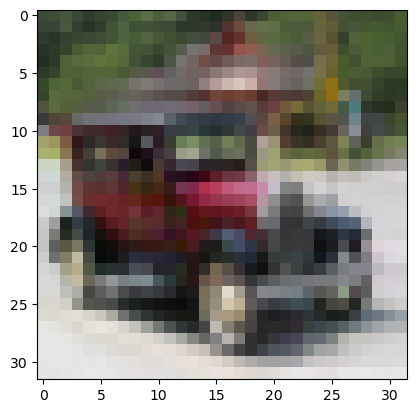

In [72]:
def l_2_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=100/1000, max_h = 10):
    x_hat = x.clone()
    loss = loss_fn(model(x), y)
    i = 1
    h = max_h
    while i < N and prediction(model, x_hat)[0] == y:
        if i % (N // max_h) == 0:
            if h > 2:
                h -= 1
        delta = l_2_dist(x_hat, x, h=h, epsilon=epsilon, w=w, c=c)
        x_new = x_hat + delta
        x_new = torch.clamp(x_new, 0, 1)
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat

img = process_image(IMG_PATH)
label = prediction(model, process_image(IMG_PATH))[0]
loss_fn = torch.nn.CrossEntropyLoss()
x_adv = l_2_square_attack(model, loss_fn, img, label, 5000)
pred = prediction(model, x_adv)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")
show_image(x_adv)